In [28]:
from warnings import filterwarnings
filterwarnings(action='ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

import scipy.stats as stats
from scipy.stats import zscore

from sklearn.metrics import classification_report,accuracy_score,precision_score,confusion_matrix
from sklearn.metrics import recall_score,f1_score,balanced_accuracy_score,roc_curve
from sklearn.metrics import precision_recall_curve,log_loss,cohen_kappa_score,roc_auc_score

from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier

import re

from sklearn.feature_selection import SelectKBest,VarianceThreshold

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

In [29]:
link_imb_rf = 'F:\GREAT LAKES\PROJECT\CAPSTONE\SMOTE_NC_Decision_Tree&_Random_Forest_data\Dummy_encoded_data.csv'

In [30]:
link_nc_rf = 'F:\GREAT LAKES\PROJECT\CAPSTONE\SMOTE_NC_Decision_Tree&_Random_Forest_data\SMOTENC_Dummy_encoded_data_reduced_size.csv'

In [31]:
df = pd.read_csv(link_nc_rf)
df = df.iloc[:,1:]

In [32]:
df_tree = df.copy()

In [33]:
Training_data = df_tree.drop('readmitted',1)
Target_balanced = df_tree[['readmitted']]

In [34]:
patient_info = ['race', 'gender', 'age', 'admission_type_id',
                'discharge_disposition_id','admission_source_id',
                'medical_specialty','diagnosis_1','diagnosis_2', 'diagnosis_3',
                'max_glu_serum', 'A1Cresult','change', 'diabetesMed']

# Features which contains no information
drop_list_patient_info = ['encounter_id','patient_nbr','weight','payer_code']

# Numeric features
patient_info_numeric = ['time_in_hospital','num_lab_procedures',
                        'num_procedures','num_medications',
                        'number_outpatient','number_emergency',
                        'number_inpatient','number_diagnoses']

# Taking initial decision to keep 16 features
feature_medicine = ['metformin','repaglinide', 'nateglinide', 
                     'chlorpropamide', 'glimepiride', 'glipizide', 
                     'glyburide', 'tolbutamide','pioglitazone',
                     'rosiglitazone', 'acarbose', 'miglitol','tolazamide',
                     'insulin','glyburide-metformin', 'glipizide-metformin']

# Initial decision to remove 7 features
drop_list_medicine = ['acetohexamide','troglitazone','examide','citoglipton',
                      'glimepiride-pioglitazone','metformin-rosiglitazone',
                      'metformin-pioglitazone']


# The medicines which contains 'Steady' & 'No' for encoding purpose
two_category_medicine = ['acetohexamide', 'tolbutamide', 'troglitazone',
                         'glipizide-metformin', 'glimepiride-pioglitazone',
                         'metformin-rosiglitazone', 'metformin-pioglitazone']
# ------------------------------------------------------------------
# The medicines which contains 'Steady','Up','Down' & 'No' for encoding purpose (14)
four_category_medicine = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide',
                          'glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone',
                          'acarbose','miglitol','tolazamide','insulin','glyburide-metformin'] 
# ------------------------------------------------------------------
# considering these two medicines with only 'steady' & 'No' categories for encoding purpose
two_category_medicine_to_be_kept = ['tolbutamide','glipizide-metformin']
# ------------------------------------------------------------------                                                
# Out of initial removal decision, these 2 are compulsorily removed.
single_category_medicine = ['examide', 'citoglipton']
                                             

print(set(drop_list_medicine) & set(two_category_medicine))

dependent = 'readmitted'

{'troglitazone', 'metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'acetohexamide'}


In [35]:
def cv_report(Model,Training_data,Target_imbalanced):
    X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_imbalanced,
                                                        test_size=0.25, random_state=42,
                                                        stratify=Target_imbalanced)
    ba = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),
                         scoring='balanced_accuracy').mean()
    pr = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='precision').mean()
    re = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='recall').mean()
    f1 = cross_val_score(Model,X_train,y_train,cv=StratifiedKFold(),scoring='f1').mean()
    print(f"Balanced accuracy : {ba}")
    print(f"Precision : {pr}")
    print(f"recall : {re}")
    print(f"F1-score : {f1}")

In [36]:
X_train, X_test, y_train, y_test = train_test_split(Training_data,Target_balanced, 
                                                    test_size=0.25,random_state=93)

In [37]:
Ada_boost = AdaBoostClassifier(n_estimators=75,random_state=93,learning_rate=0.8)
Ada_boost.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=75, random_state=93)

In [38]:
print(classification_report(y_train,Ada_boost.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     67220
           1       0.92      0.86      0.89     67286

    accuracy                           0.89    134506
   macro avg       0.90      0.89      0.89    134506
weighted avg       0.90      0.89      0.89    134506



In [39]:
Feature_imp_ada = pd.DataFrame(data={'Feature': Training_data.columns,
                                     'Feature_importance': Ada_boost.feature_importances_})
Feature_imp_ada = Feature_imp_ada.sort_values(by='Feature_importance',
                                                ascending=0,ignore_index=True)

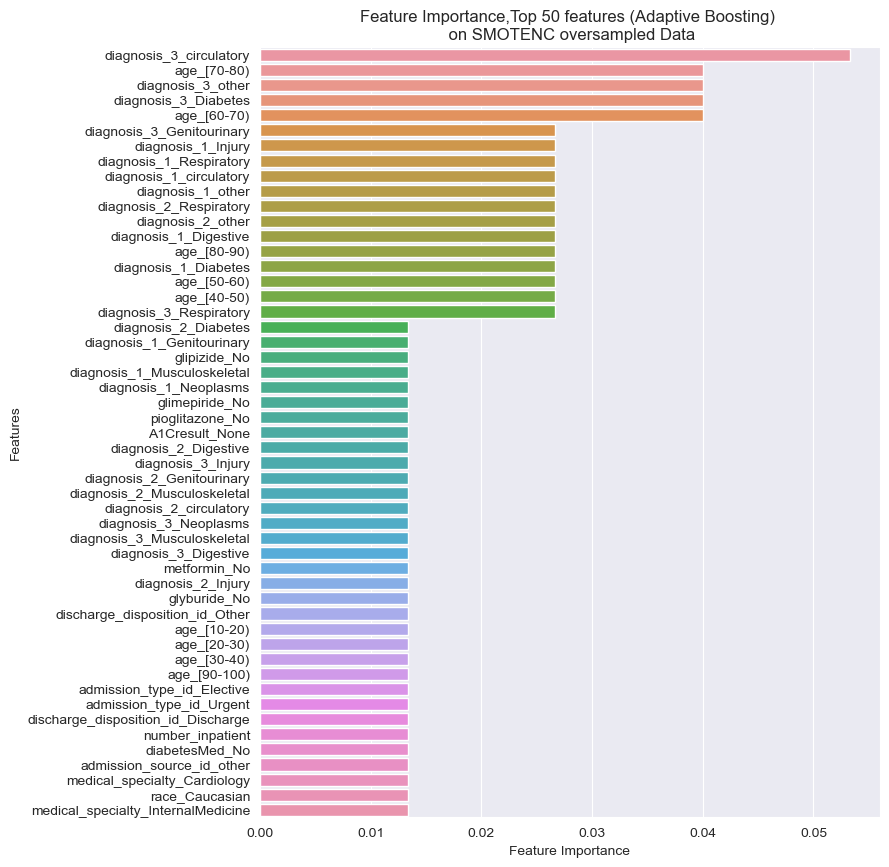

In [61]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,10))
sns.barplot(data=Feature_imp_ada[Feature_imp_ada['Feature_importance']!= 0],x='Feature_importance',y='Feature',
            orient='horizontal')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance,Top 50 features (Adaptive Boosting) \n on SMOTENC oversampled Data")
plt.show()

## `Feature Engineering`

In [21]:
link_smote = 'F:\GREAT LAKES\PROJECT\Different_datasets\Original_iterative_imputed_SMOTENC_data\Original_SMOTENC_after_imputation_1790000.csv'

df_smote = pd.read_csv(link_smote)
df_smote = df_smote.iloc[:,1:]

# Health_index = 1 / (number_emergency + number_inpatient + number_outpatient)
# severity_of_disease = (time_in_hospital(in days) + num_procedures + num_medications + num_lab_procedures + number_of_diagnoses)

# Based on frequency of patient’s visit to the hospital is high 
# then we can say that patient is less healthier and 
# less healthier patient tends to readmit quickly. 
# Higher the health_index lesser the chance that person will readmit (inversely proportional)

hospital_data = (df_smote['number_outpatient'] + df_smote['number_emergency'] + df_smote['number_inpatient'])
health_index = hospital_data

# for some of the patients there is no visit, hence denominator = 0 let's make health index as 1
health_index.loc[health_index == np.inf] = 1

# Severity of disease  is the feature created based on time spent in hospital, 
# number of procedures, medications taken by patient. 
# For probabilistic interpretation we divided it by total values.

severity = (df_smote['time_in_hospital'] + df_smote['num_lab_procedures'] + df_smote['num_procedures'] + df_smote['num_medications'] + df_smote['number_diagnoses'])

severity_of_disease = severity

health_index_std = pd.DataFrame(health_index,columns=['Health_index'])
severity_of_disease_std = pd.DataFrame(severity_of_disease,columns=['Severity_of_disease'])

# lets add 'severity index' & 'health_index' to SMOTE resampled data

predictor_nc_f = pd.concat([Training_data,health_index_std,severity_of_disease_std],axis=1)
Target_nc_f = Target_balanced

In [22]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(predictor_nc_f,Target_nc_f, 
                                                    test_size=0.25, random_state=93)

In [23]:
Ada_boost_f = AdaBoostClassifier(n_estimators=75,learning_rate=0.8,random_state=93)
Ada_boost_f.fit(Xf_train,yf_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=75, random_state=93)

In [24]:
print(classification_report(yf_train,Ada_boost.predict(Xf_train)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     67220
           1       0.92      0.86      0.89     67286

    accuracy                           0.89    134506
   macro avg       0.90      0.89      0.89    134506
weighted avg       0.90      0.89      0.89    134506



In [57]:
ada_sub_precision_train = []
ada_sub_recall_train = []
ada_sub_f1_score_train = []

ada_sub_precision_test = []
ada_sub_recall_test = []
ada_sub_f1_score_test = []

for n_features in range(10,60,5):
    subset_features = Feature_imp_ada.nlargest(n_features,
                                              columns=['Feature_importance'])['Feature'].values
    ada_model_subset = AdaBoostClassifier(n_estimators=100,learning_rate=0.8,random_state=93)
    subset_train = Xf_train[subset_features]
    subset_test = Xf_test[subset_features]
    subset_train_target = yf_train
    subset_test_target = yf_test
    ada_model_subset.fit(subset_train,subset_train_target)    
    # precision
    ada_sub_precision_train.append(precision_score(subset_train_target,ada_model_subset.predict(subset_train)))
    ada_sub_precision_test.append(precision_score(subset_test_target,ada_model_subset.predict(subset_test)))
    # Recall
    ada_sub_recall_train.append(recall_score(subset_train_target,ada_model_subset.predict(subset_train)))
    ada_sub_recall_test.append(recall_score(subset_test_target,ada_model_subset.predict(subset_test)))
    # f1_score
    ada_sub_f1_score_train.append(f1_score(subset_train_target,ada_model_subset.predict(subset_train)))
    ada_sub_f1_score_test.append(f1_score(subset_test_target,ada_model_subset.predict(subset_test)))

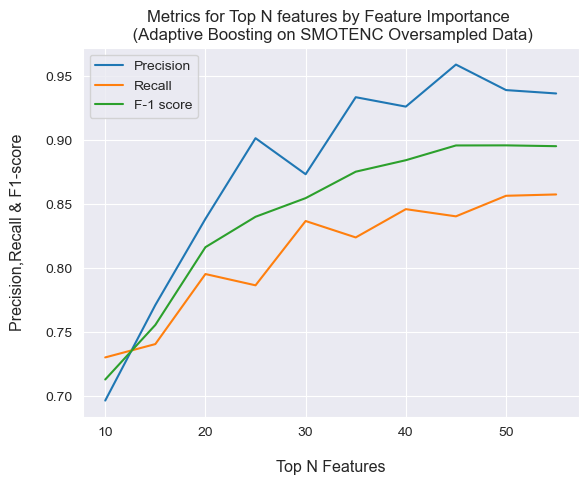

In [60]:
sns.set_style('darkgrid')
sns.lineplot(range(10,60,5),ada_sub_precision_train,label='Precision')
sns.lineplot(range(10,60,5),ada_sub_recall_train,label='Recall')
sns.lineplot(range(10,60,5),ada_sub_f1_score_train,label='F-1 score')

plt.xlabel("Top N Features",fontsize=11.5,labelpad=15)
plt.ylabel("Precision,Recall & F1-score",fontsize=11.5,labelpad=15)
plt.title("Metrics for Top N features by Feature Importance \n (Adaptive Boosting on SMOTENC Oversampled Data)")
plt.show()